#INTRODUCCIÓN

¿Es posible desarrollar un detector de tendencias sólo con un indicador y clusterización?

Se va a comprobar si es posible con el Williams %R, que no es más que una normalización del precio.

La hipótesis es que si el indicador tiene la mínima capacidad predictiva, con la generación de 2 clústers obtendremos un clúster que se identifica con las tendencias alcistas y otro con las tendencias bajistas.

Para comprobarlo se realizarán los siguientes pasos:

1) cálculo del Williams %R para un rango de parámetros a modo de variables

2) generación de 2 clústers con K-Means en el periodo de entrenamiento

3) comprobación en forward

Se utilizarán los siguientes periodos:

- train: 01/01/2010 -01/01/2020
- forward: 01/01/2020 - 01/01/2023

#ENTORNO

##DATOS

El activo utilizado en este código será el EURUSD en diario disponible en los siguientes enlaces:

- descarga: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ

- visualización: https://drive.google.com/file/d/1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ/view?usp=sharing

##LIBRERÍAS

In [5]:
#INSTALACIÓN DE LIBRERÍA PARA CALCULAR INDICADORES TÉCNICOS
!pip install pandas_ta
!pip install yfinance
!pip install wittgenstein
!pip install pyRofex

In [99]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas_ta as ta
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import date
from scipy.stats import ks_2samp
import warnings
import yfinance as yf
import pyRofex
import time
warnings.filterwarnings('ignore')

##FUNCIONES

In [96]:
#FUNCIÓN PARA CALCULAR WILLIAMS de yaju

def calculate_williams_ya(data):
  """
  Calcula Williams %R para un rango de parámetros para los datos de precios de un activo específico.

  Args:
    data (pandas.DataFrame): Datos históricos del activo.

  Returns:
    pandas.DataFrame: Un DataFrame que contiene los indicadores calculados.
  """
#Open         High          Low        Close    Adj Close  \
  #Renombrar las columnas
  #data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  #print("columnas")
  data.columns = ["Open", "High", "Low", "Close", "AjClose", "Volume"]
  #print("columnas arregladas")

  #Establecer la fecha como índice
  #data = data.set_index("Date")
  #Eliminar columnas innecesarias
  #print("vola vol")
  data = data.drop(["Volume"], axis=1)
  #print("vola clos")
  data = data.drop(["AjClose"], axis=1)
  #print("vola volo")
  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #Establecer rango de valores usados como parámetro para el cálculo de los indicadores
  periods = list(range(5,100))

  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index

  #Calcular el retorno a un día vista
  df["Open"] = round(data["Open"],2)
  df["Close"] = round(data["Close"],2)
  df["Return"] = round(df["Open"].pct_change().shift(-1),4)
  # Supongamos que tienes un DataFrame llamado "df" con las fechas en el índice y el precio de cierre en una columna llamada "Close"
  # Primero, calcula la diferencia entre el precio de cierre de un día y el precio de cierre del día anterior
  df['Price_Diff'] = df['Close'].diff()

# Luego, asigna 1 si el precio actual es mayor o igual que el del día anterior, y -1 si es menor
  #df['Sentido'] = df['Price_Diff'].apply(lambda x: 1 if x >= 0 else -1)
  df = df.drop("Open",  axis=1)
  df = df.drop("Price_Diff",  axis=1)

  #Eliminar las filas con valores faltantes
  #df = df.dropna()

  return df

In [8]:
def split(data, numero_barras):
    """
    Divide los datos en conjuntos de entrenamiento y forward, dejando las últimas dos filas en forward.

    Args:
      data (pandas.DataFrame): DataFrame que contiene los datos a dividir.

    Returns:
      tuple: Una tupla que contiene los siguientes conjuntos de datos:
        - train (pandas.DataFrame): Conjunto de entrenamiento.
        - forward (pandas.DataFrame): Conjunto forward.
    """
    # Dejar las últimas dos filas en forward
    forward = data.iloc[-numero_barras:, :]

    # Resto de las filas en train
    train = data.iloc[:-numero_barras, :]

    return train, forward


#DATASET

In [105]:

papeles = ["ALUA.BA", "BBAR.BA", "BMA.BA", "BYMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA",
"GGAL.BA", "LOMA.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA",
"TXAR.BA", "VALO.BA", "YPFD.BA"]

symbol = "EDN.BA"

start_date="2010-01-01"

end_date="2024-03-31"

data =yf.download(symbol, start=start_date, end=end_date)
# Convertir los datos en un DataFrame de pandas
data_df = pd.DataFrame(data)

#data_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

#data_df.reindex(columns=['fecha', 'especie', 'apertura', 'maximo', 'minimo', 'cierre', 'volumen', 'timestamp'])

print("                mis datos")
#print(data_df)
print("findatos")
#msft = yf.Ticker("COME.BA")




# get historical market data
#hist = msft.history(period="1mo")



[*********************100%%**********************]  1 of 1 completed

                mis datos
findatos


In [106]:
#Calcular indicadores
data = calculate_williams_ya(data_df)
#print(data)
print("tatime")
data_trimmed = data.iloc[:-2]
#print(data_trimmed)

#Realizar particiones
train, forward = split(data, 100)

train= train.dropna()
train.head(3)

print("fowar")
#forward

tatime
fowar


#CLUSTERING

In [107]:
#GENERACIÓN DE CLÚSTERS

#Preparar datos de entrenamiento
#print(X_train.head(5))

X_train = train.iloc[:,:-2]

#print(X_train.head(5))

#Preparar datos forward
X_forward = forward.iloc[:,:-2]

#Aplicar K-Means
kmeans = KMeans(n_clusters=2).fit(X_train)
predictions = kmeans.predict(X_forward)

#Generar predicciones en forward
df_forward = pd.DataFrame(forward["Return"])
#df_forward["Sentido"] = forward["Sentido"]
df_forward["Pred"] = predictions
df_forward["Close"] = forward["Close"]
df_forward.tail(108)

,Return,Pred,Close
Date,,,
2023-10-25,0.0194,1,551.15
2023-10-26,-0.0372,1,548.65
2023-10-27,-0.0283,0,514.60
2023-10-30,-0.1068,0,460.00
2023-10-31,-0.0391,0,441.50
...,...,...,...
2024-03-15,0.0376,0,814.45
2024-03-18,0.1220,0,915.45
2024-03-19,0.0043,0,923.50


In [108]:
#COMPROBACIÓN DE CLÚSTERS

#Calcular retornos medios del clúster con la etiqueta 0
ave_zero = np.mean(df_forward[df_forward["Pred"]==0]["Return"])
print("Retorno medio de la etiqueta 0:", round(ave_zero, 4))

#Calcular retornos medios del clúster con la etiqueta 1
ave_one = np.mean(df_forward[df_forward["Pred"]==1]["Return"])
print("Retorno medio de la etiqueta 1:", round(ave_one, 4))

#Calcular retornos medios del clúster con la etiqueta 2
ave_dos = np.mean(df_forward[df_forward["Pred"]==2]["Return"])
print("Retorno medio de la etiqueta 2:", round(ave_dos, 4))

Retorno medio de la etiqueta 0: -0.0061
Retorno medio de la etiqueta 1: 0.0198
Retorno medio de la etiqueta 2: nan


In [109]:
#RENOMBRADO DE LAS ETIQUETAS OTORGADAS POR K-MEANS EN 1 O -1

#Renombrar etiquetas
if ave_zero > ave_one:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, 1, -1)
else:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, -1, 1)

In [110]:
#FORMATO DE FECHAS
dates = pd.to_datetime(df_forward.index)
df_forward.set_index(dates, inplace=True)

print(df_forward)

cabeza= df_forward.head(400)
cola = df_forward.tail(300)

cola.tail(10)

            Return  Pred    Close
Date                             
2023-10-25  0.0194     1   551.15
2023-10-26 -0.0372     1   548.65
2023-10-27 -0.0283    -1   514.60
2023-10-30 -0.1068    -1   460.00
2023-10-31 -0.0391    -1   441.50
...            ...   ...      ...
2024-03-15  0.0376    -1   814.45
2024-03-18  0.1220    -1   915.45
2024-03-19  0.0043    -1   923.50
2024-03-20  0.1129    -1  1008.35
2024-03-21     NaN     1  1018.50

[100 rows x 3 columns]


,Return,Pred,Close
Date,,,
2024-03-08,0.0703,-1,839.75
2024-03-11,-0.0674,-1,801.30
2024-03-12,0.1222,-1,881.10
2024-03-13,-0.0789,-1,819.25
2024-03-14,-0.0467,-1,793.05
2024-03-15,0.0376,-1,814.45
2024-03-18,0.1220,-1,915.45
2024-03-19,0.0043,-1,923.50
2024-03-20,0.1129,-1,1008.35


#COMPROBACIONES

##GRÁFICO

Graficando la evolución del precio pintando cada punto según el clúster podremos comprobar si se distinguen tendencias alcistas y bajistas.

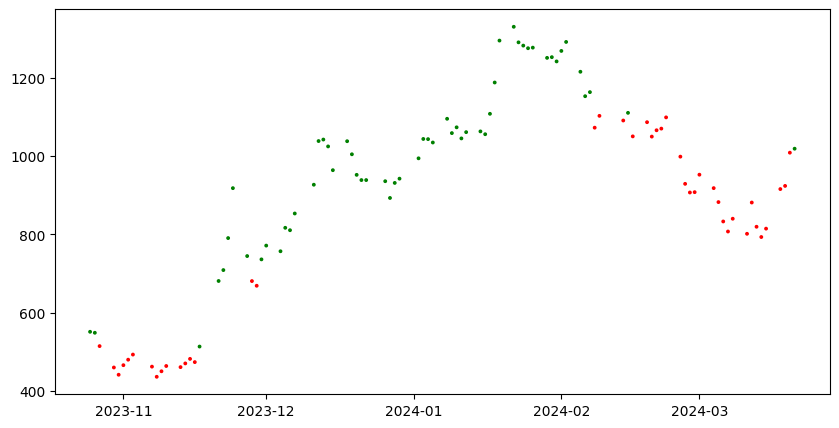

In [111]:
#GRÁFICO CON LAS PREDICCIONES

#Crear una lista de colores según predicción
colors = ['green' if c == 1 else 'red' for c in df_forward["Pred"]]


#Crear el gráfico
plt.figure(figsize=(10, 5))
plt.scatter(cola.index, cola["Close"], c=colors, s=3)
plt.show()

##HISTOGRAMAS

Superponiendo el histograma de los retornos correspondientes a cada clúster podremos comprobar las diferencias entre cada clúster.

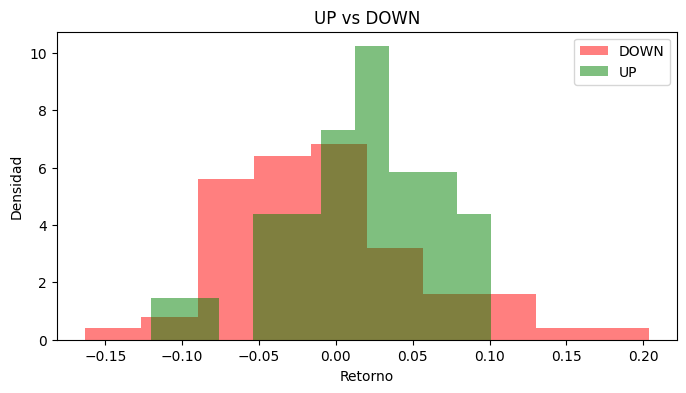

In [47]:
#HISTOGRAMAS SUPERPUESTOS DE LOS RETORNOS DE LOS CLÚSTERS

#Generar histogramas
plt.figure(figsize=(8, 4))
plt.hist(df_forward[df_forward["Pred"]==-1]["Return"], density=True, alpha=0.5, color="red", label="DOWN")
plt.hist(df_forward[df_forward["Pred"]==1]["Return"], density=True, alpha=0.5, color="green", label="UP")
plt.xlabel("Retorno")
plt.ylabel("Densidad")
plt.title("UP vs DOWN")
plt.legend()
plt.show()

##TEST ESTADÍSTICO

Realizando el test de Kolmogorov-Smirnov podremos confirmar si los clústers son significativamente diferentes: el estadístico nos mostrará la magnitud de la diferencia y el p_value la fiabilidad del test.

In [48]:
#TEST DE KOLMOGOROV-SMIRNOV

#Aplicar test de Kolmogorov-Smirnov
statistic, p_value = ks_2samp(df_forward.loc[df_forward["Pred"] == 1, "Return"],
                              df_forward.loc[df_forward["Pred"] == -1, "Return"])

print("Estadístico:", statistic)
print("P_value:", p_value)

Estadístico: 0.36764705882352944
P_value: 0.0038701209173874645


#CONCLUSIÓN

\:Se ha podido comprobar visual y estadísticamente que un único indicador es suficiente para distinguir tendencias con clusterización.


In [ ]:
import pandas as pd

# Lista de activos
activos = ['GGAL', 'META', 'COME', 'SEMIO']

# Ejemplo de datos
data = pd.DataFrame({
    'Date': ['2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23'],
    'Pred': [17, 180, 19, 20, 23],
    'Close': [1744.250000, 1673.000000, 1622.900024, 1738.849976, 1534.650024]
})

# Convertir la columna 'Date' a datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear un DataFrame vacío para almacenar los datos pivoteados
datos_pivotados = pd.DataFrame(index=data['Date'])

# Iterar sobre la lista de activos
for activo in activos:
    print(activo)
    print(data['Pred'])
    # Agregar los datos de predicción del activo al DataFrame pivoteado
    datos_pivotados[activo] = data['Pred']

print(datos_pivotados)
# Transponer el DataFrame para que los activos estén en filas y las fechas en columnas
datos_pivotados = datos_pivotados.transpose()

print(data)
# Imprimir el DataFrame pivoteado
print(datos_pivotados)




GGAL
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
META
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
COME
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
SEMIO
0     17
1    180
2     19
3     20
4     23
Name: Pred, dtype: int64
            GGAL  META  COME  SEMIO
Date                               
2023-10-17   NaN   NaN   NaN    NaN
2023-10-18   NaN   NaN   NaN    NaN
2023-10-19   NaN   NaN   NaN    NaN
2023-10-20   NaN   NaN   NaN    NaN
2023-10-23   NaN   NaN   NaN    NaN
        Date  Pred        Close
0 2023-10-17    17  1744.250000
1 2023-10-18   180  1673.000000
2 2023-10-19    19  1622.900024
3 2023-10-20    20  1738.849976
4 2023-10-23    23  1534.650024
Date   2023-10-17  2023-10-18  2023-10-19  2023-10-20  2023-10-23
GGAL          NaN         NaN         NaN         NaN         NaN
META          NaN         NaN         NaN         NaN         NaN
COME          NaN         NaN         NaN         NaN    

In [4]:

# Endpoint selection (depends on your broker account)
api_url = "https://api.bull.xoms.com.ar/"
ws_url = "wss://api.bull.xoms.com.ar/"

pyRofex._set_environment_parameter("url", api_url, pyRofex.Environment.LIVE)
pyRofex._set_environment_parameter("ws", ws_url, pyRofex.Environment.LIVE)

#Initialize the environment
pyRofex.initialize(user="xxxxxxxxxxxx",
                   password="xxxxxxxxxxxx",
                   account="xxxxxxxx",
                   environment=pyRofex.Environment.LIVE)




pyRofex.set_default_environment(pyRofex.Environment.LIVE)

detalle1 = pyRofex.get_instrument_details(ticker='MERV - XMEV - AE38 - CI')

tiki = detalle1["instrument"]["minPriceIncrement"]

print(tiki)



5.0


In [117]:

papeles = ["ALUA.BA", "BBAR.BA", "BMA.BA", "BYMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA",
"GGAL.BA", "LOMA.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA",
"TXAR.BA", "VALO.BA", "YPFD.BA"]



start_date="2010-01-01"

end_date="2024-08-31"





# Iterar sobre la lista de activos
for activo in papeles:

    # Copiar los datos del DataFrame original
    symbol = activo
    print(symbol + " ini")
    try:

      data =yf.download(symbol, start=start_date, end=end_date,)

      # Convertir los datos en un DataFrame de pandas
      data_df = pd.DataFrame(data)



      #Calcular indicadores
      data = calculate_williams_ya(data_df)
      #print(data)

      data_trimmed = data.iloc[:-2]
      #print(data_trimmed)

      #Realizar particiones
      train, forward = split(data, 100)

      train= train.dropna()

      #GENERACIÓN DE CLÚSTERS

      #Preparar datos de entrenamiento
      #print(X_train.head(5))

      X_train = train.iloc[:,:-2]

      #print(X_train.head(5))

      #Preparar datos forward
      X_forward = forward.iloc[:,:-2]


      # Resetear K-Means
      kmeans = KMeans(n_clusters=2)
      #Aplicar K-Means
      kmeans = KMeans(n_clusters=2).fit(X_train)
      predictions = kmeans.predict(X_forward)

      #Generar predicciones en forward
      df_forward = pd.DataFrame(forward["Return"])
      #df_forward["Sentido"] = forward["Sentido"]
      df_forward["Pred"] = predictions
      df_forward["Close"] = forward["Close"]

      #COMPROBACIÓN DE CLÚSTERS

      #Calcular retornos medios del clúster con la etiqueta 0
      ave_zero = np.mean(df_forward[df_forward["Pred"]==0]["Return"])
      print("Retorno medio de la etiqueta 0:", round(ave_zero, 4))

      #Calcular retornos medios del clúster con la etiqueta 1
      ave_one = np.mean(df_forward[df_forward["Pred"]==1]["Return"])
      print("Retorno medio de la etiqueta 1:", round(ave_one, 4))

      #Calcular retornos medios del clúster con la etiqueta 2
      #ave_dos = np.mean(df_forward[df_forward["Pred"]==2]["Return"])
      #print("Retorno medio de la etiqueta 2:", round(ave_dos, 4))

      #RENOMBRADO DE LAS ETIQUETAS OTORGADAS POR K-MEANS EN 1 O -1

      #Renombrar etiquetas
      if ave_zero > ave_one:
        df_forward["Pred"] = np.where(df_forward["Pred"]==0, 1, -1)
      else:
        df_forward["Pred"] = np.where(df_forward["Pred"]==0, -1, 1)

      #FORMATO DE FECHAS
      dates = pd.to_datetime(df_forward.index)
      df_forward.set_index(dates, inplace=True)

      #print(df_forward)

      cabeza= df_forward.head(400)
      cola = df_forward.tail(300)

      print(symbol)

      print(cola.tail(10))
    except Exception as E:

      print(symbol + " fini")
    time.sleep(7)

# Imprimir los DataFrames de cada activo



ALUA.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0158
Retorno medio de la etiqueta 1: -0.0052
Retorno medio de la etiqueta 2: nan
ALUA.BA
            Return  Pred  Close
Date                           
2024-03-08 -0.0204    -1  748.5
2024-03-11 -0.0268    -1  716.5
2024-03-12  0.0999    -1  771.0
2024-03-13  0.0138    -1  801.0
2024-03-14 -0.0167    -1  795.5
2024-03-15 -0.0195    -1  789.5
2024-03-18  0.0128    -1  789.5
2024-03-19  0.0937    -1  854.0
2024-03-20  0.0411    -1  896.5
2024-03-21     NaN     1  938.5


[*********************100%%**********************]  1 of 1 completed

BBAR.BA ini


Retorno medio de la etiqueta 0: 0.0022
Retorno medio de la etiqueta 1: 0.0144
Retorno medio de la etiqueta 2: nan
BBAR.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0000     1  2550.65
2024-03-11 -0.0392     1  2383.35
2024-03-12  0.0816     1  2579.90
2024-03-13  0.0302     1  2736.60
2024-03-14 -0.0473     1  2661.90
2024-03-15  0.0765     1  2795.50
2024-03-18  0.0500     1  2891.85
2024-03-19 -0.0306     1  2844.05
2024-03-20  0.0547     1  2996.75
2024-03-21     NaN     1  3059.50
BMA.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: -0.0249
Retorno medio de la etiqueta 1: 0.0232
Retorno medio de la etiqueta 2: nan
BMA.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0164     1  4176.25
2024-03-11 -0.0420     1  3967.20
2024-03-12  0.1000     1  4278.40
2024-03-13  0.0109     1  4444.20
2024-03-14 -0.0330     1  4396.95
2024-03-15  0.0939     1  4688.20
2024-03-18  0.0584     1  4873.75
2024-03-19 -0.0060     1  4930.35
2024-03-20  0.0841     1  5276.50
2024-03-21     NaN     1  5623.45
BYMA.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: -0.006
Retorno medio de la etiqueta 1: 0.0181
Retorno medio de la etiqueta 2: nan
BYMA.BA
            Return  Pred   Close
Date                            
2024-03-08 -0.0455    -1  1046.0
2024-03-11 -0.0381    -1  1006.0
2024-03-12  0.0693    -1  1078.5
2024-03-13  0.1065     1  1185.0
2024-03-14 -0.0343     1  1161.5
2024-03-15  0.0399     1  1188.0
2024-03-18  0.0729     1  1287.5
2024-03-19 -0.0369     1  1236.5
2024-03-20  0.0738     1  1298.0
2024-03-21     NaN     1  1330.0
CEPU.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0143
Retorno medio de la etiqueta 1: 0.0001
Retorno medio de la etiqueta 2: nan
CEPU.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0237    -1   823.60
2024-03-11 -0.0366    -1   788.80
2024-03-12  0.1020    -1   848.20
2024-03-13 -0.0408    -1   827.65
2024-03-14 -0.0129    -1   821.70
2024-03-15  0.0459    -1   851.10
2024-03-18  0.1382    -1   956.70
2024-03-19 -0.0357    -1   947.65
2024-03-20  0.0847     1  1014.75
2024-03-21     NaN     1  1060.00


[*********************100%%**********************]  1 of 1 completed

COME.BA ini


Retorno medio de la etiqueta 0: -0.0022
Retorno medio de la etiqueta 1: 0.0107
Retorno medio de la etiqueta 2: nan
COME.BA
            Return  Pred   Close
Date                            
2024-03-08  0.0011    -1   94.05
2024-03-11 -0.0329    -1   90.95
2024-03-12  0.0989    -1   97.65
2024-03-13  0.0095     1  100.75
2024-03-14 -0.0490    -1   97.00
2024-03-15  0.0417    -1   98.95
2024-03-18  0.0060     1  100.65
2024-03-19  0.0338     1  103.10
2024-03-20  0.0192     1  105.45
2024-03-21     NaN     1  108.25
CRES.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0152
Retorno medio de la etiqueta 1: -0.0054
Retorno medio de la etiqueta 2: nan
CRES.BA
            Return  Pred   Close
Date                            
2024-03-08  0.0442    -1  838.65
2024-03-11 -0.0547    -1  803.75
2024-03-12  0.0828    -1  863.70
2024-03-13 -0.0184    -1  853.55
2024-03-14 -0.0273    -1  837.40
2024-03-15  0.0256    -1  849.10
2024-03-18  0.0505    -1  897.05
2024-03-19 -0.0106    -1  884.55
2024-03-20  0.0409    -1  926.30
2024-03-21     NaN    -1  967.00
CVH.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: -0.0025
Retorno medio de la etiqueta 1: 0.0129
Retorno medio de la etiqueta 2: nan
CVH.BA
            Return  Pred   Close
Date                            
2024-03-08  0.0723    -1  3685.5
2024-03-11 -0.0746    -1  3532.0
2024-03-12  0.1143    -1  3726.5
2024-03-13 -0.0859    -1  3564.5
2024-03-14  0.0266    -1  3654.0
2024-03-15  0.0765    -1  3831.0
2024-03-18 -0.0051    -1  3889.5
2024-03-19  0.0204    -1  3968.5
2024-03-20  0.0437     1  4143.5
2024-03-21     NaN     1  4434.0
EDN.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0198
Retorno medio de la etiqueta 1: -0.0061
Retorno medio de la etiqueta 2: nan
EDN.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0703    -1   839.75
2024-03-11 -0.0674    -1   801.30
2024-03-12  0.1222    -1   881.10
2024-03-13 -0.0789    -1   819.25
2024-03-14 -0.0467    -1   793.05
2024-03-15  0.0376    -1   814.45
2024-03-18  0.1220    -1   915.45
2024-03-19  0.0043    -1   923.50
2024-03-20  0.1129    -1  1008.35
2024-03-21     NaN     1  1013.00


[*********************100%%**********************]  1 of 1 completed

GGAL.BA ini


Retorno medio de la etiqueta 0: 0.007
Retorno medio de la etiqueta 1: 0.0133
Retorno medio de la etiqueta 2: nan
GGAL.BA
            Return  Pred    Close
Date                             
2024-03-08 -0.0204    -1  2340.20
2024-03-11 -0.0244    -1  2221.75
2024-03-12  0.0907     1  2437.15
2024-03-13  0.0198     1  2552.20
2024-03-14 -0.0276     1  2479.70
2024-03-15  0.0405     1  2564.80
2024-03-18  0.0322     1  2669.10
2024-03-19 -0.0066     1  2621.55
2024-03-20  0.0548     1  2780.40
2024-03-21     NaN     1  2849.00


[*********************100%%**********************]  1 of 1 completed

LOMA.BA ini


Retorno medio de la etiqueta 0: 0.0089
Retorno medio de la etiqueta 1: 0.0003
Retorno medio de la etiqueta 2: nan
LOMA.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0948    -1  1415.40
2024-03-11 -0.0554    -1  1357.75
2024-03-12  0.0987    -1  1435.75
2024-03-13 -0.0017    -1  1448.15
2024-03-14 -0.0220    -1  1457.35
2024-03-15 -0.0138    -1  1483.15
2024-03-18  0.0877    -1  1536.25
2024-03-19 -0.0173    -1  1519.55
2024-03-20  0.0592     1  1580.00
2024-03-21     NaN     1  1585.00


[*********************100%%**********************]  1 of 1 completed

MIRG.BA ini


Retorno medio de la etiqueta 0: -0.0076
Retorno medio de la etiqueta 1: 0.0127
Retorno medio de la etiqueta 2: nan
MIRG.BA
            Return  Pred    Close
Date                             
2024-03-08  0.1251    -1  12066.0
2024-03-11 -0.0947    -1  11142.5
2024-03-12  0.0726    -1  11450.5
2024-03-13 -0.0062    -1  11726.0
2024-03-14 -0.0235    -1  11455.0
2024-03-15  0.0449    -1  11964.0
2024-03-18  0.0359    -1  12292.0
2024-03-19  0.1418     1  13850.5
2024-03-20 -0.0107     1  13885.0
2024-03-21     NaN     1  13700.5
PAMP.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0091
Retorno medio de la etiqueta 1: -0.0017
Retorno medio de la etiqueta 2: nan
PAMP.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0379    -1  1668.50
2024-03-11 -0.0535    -1  1604.15
2024-03-12  0.0814    -1  1700.00
2024-03-13 -0.0454    -1  1665.15
2024-03-14  0.0054    -1  1663.40
2024-03-15  0.0329    -1  1711.35
2024-03-18  0.0725    -1  1839.05
2024-03-19 -0.0108    -1  1817.20
2024-03-20  0.0683    -1  1921.90
2024-03-21     NaN    -1  1933.50


[*********************100%%**********************]  1 of 1 completed

SUPV.BA ini


Retorno medio de la etiqueta 0: 0.0209
Retorno medio de la etiqueta 1: 0.0034
Retorno medio de la etiqueta 2: nan
SUPV.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0072     1   977.65
2024-03-11 -0.0787    -1   898.60
2024-03-12  0.0721    -1   962.40
2024-03-13  0.1223     1  1090.35
2024-03-14 -0.0397     1  1043.40
2024-03-15  0.1029     1  1146.75
2024-03-18  0.0244     1  1169.05
2024-03-19  0.0213     1  1199.20
2024-03-20  0.0425     1  1242.10
2024-03-21     NaN     1  1293.50


[*********************100%%**********************]  1 of 1 completed

TECO2.BA ini


Retorno medio de la etiqueta 0: -0.0008
Retorno medio de la etiqueta 1: 0.0139
Retorno medio de la etiqueta 2: nan
TECO2.BA
            Return  Pred    Close
Date                             
2024-03-08  0.1117    -1  1446.40
2024-03-11 -0.0730    -1  1333.80
2024-03-12  0.0898    -1  1457.60
2024-03-13 -0.0014    -1  1465.95
2024-03-14 -0.0130    -1  1496.20
2024-03-15  0.1414    -1  1647.25
2024-03-18  0.0175    -1  1670.55
2024-03-19 -0.0023    -1  1661.35
2024-03-20  0.0714     1  1756.40
2024-03-21     NaN     1  1752.00
TGNO4.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: -0.0027
Retorno medio de la etiqueta 1: 0.0175
Retorno medio de la etiqueta 2: nan
TGNO4.BA
            Return  Pred   Close
Date                            
2024-03-08  0.0253    -1  1560.5
2024-03-11 -0.0516    -1  1497.0
2024-03-12  0.0501    -1  1580.5
2024-03-13  0.0659    -1  1670.5
2024-03-14  0.0483    -1  1768.5
2024-03-15  0.0899    -1  1874.5
2024-03-18  0.0381     1  1989.0
2024-03-19 -0.0348     1  1944.0
2024-03-20  0.0098     1  1969.0
2024-03-21     NaN     1  2003.0
TGSU2.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0132
Retorno medio de la etiqueta 1: -0.0006
Retorno medio de la etiqueta 2: nan
TGSU2.BA
            Return  Pred    Close
Date                             
2024-03-08  0.0138    -1  2560.25
2024-03-11 -0.0253    -1  2463.55
2024-03-12  0.0880    -1  2683.40
2024-03-13 -0.0441    -1  2599.45
2024-03-14 -0.0019    -1  2600.05
2024-03-15  0.0786    -1  2738.80
2024-03-18  0.0718    -1  2926.40
2024-03-19 -0.0203    -1  2941.60
2024-03-20  0.0715    -1  3131.00
2024-03-21     NaN     1  3199.75


[*********************100%%**********************]  1 of 1 completed

TRAN.BA ini


Retorno medio de la etiqueta 0: -0.0107
Retorno medio de la etiqueta 1: 0.0173
Retorno medio de la etiqueta 2: nan
TRAN.BA
            Return  Pred   Close
Date                            
2024-03-08  0.0143    -1   912.0
2024-03-11 -0.0184    -1   897.0
2024-03-12  0.1013    -1   988.0
2024-03-13  0.0680    -1  1049.5
2024-03-14 -0.0618    -1  1017.5
2024-03-15  0.0908    -1  1064.5
2024-03-18  0.0430    -1  1140.0
2024-03-19  0.0184    -1  1153.5
2024-03-20  0.0336     1  1177.5
2024-03-21     NaN     1  1185.0


[*********************100%%**********************]  1 of 1 completed

TXAR.BA ini


Retorno medio de la etiqueta 0: -0.0032
Retorno medio de la etiqueta 1: 0.0145
Retorno medio de la etiqueta 2: nan
TXAR.BA
            Return  Pred  Close
Date                           
2024-03-08 -0.0362    -1  732.5
2024-03-11 -0.0225    -1  712.5
2024-03-12  0.0349    -1  735.5
2024-03-13  0.0115    -1  750.0
2024-03-14 -0.0007    -1  746.5
2024-03-15 -0.0120    -1  737.5
2024-03-18  0.0027    -1  741.0
2024-03-19  0.0849    -1  803.5
2024-03-20  0.0435    -1  820.0
2024-03-21     NaN    -1  885.0
VALO.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0129
Retorno medio de la etiqueta 1: -0.0011
Retorno medio de la etiqueta 2: nan
VALO.BA
            Return  Pred   Close
Date                            
2024-03-08 -0.0207    -1  237.00
2024-03-11 -0.0085    -1  230.25
2024-03-12  0.0448    -1  244.25
2024-03-13  0.0000    -1  246.00
2024-03-14 -0.0102    -1  240.25
2024-03-15 -0.0144    -1  238.50
2024-03-18  0.0167    -1  241.00
2024-03-19  0.0000    -1  243.75
2024-03-20  0.0350    -1  251.00
2024-03-21     NaN    -1  254.50
YPFD.BA ini


[*********************100%%**********************]  1 of 1 completed


Retorno medio de la etiqueta 0: 0.0066
Retorno medio de la etiqueta 1: 0.0107
Retorno medio de la etiqueta 2: nan
YPFD.BA
            Return  Pred     Close
Date                              
2024-03-08  0.0097    -1  18499.30
2024-03-11 -0.0271    -1  17727.55
2024-03-12  0.0683    -1  18838.55
2024-03-13 -0.0105    -1  18956.20
2024-03-14  0.0128    -1  19071.85
2024-03-15  0.0215    -1  19300.20
2024-03-18  0.0648     1  20786.70
2024-03-19 -0.0072     1  20517.65
2024-03-20  0.0457     1  21233.90
2024-03-21     NaN     1  22268.75
